In [78]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [79]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [80]:
NUM_CLASSES = 26

# 学習データ読み込み

In [81]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))


In [82]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [83]:

X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [84]:
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers

# Clear the TensorFlow session
K.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((21, 2, 1), input_shape=(21, 2, 1)),
    tf.keras.layers.Conv2D(32, (3, 1), activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Adjusted filter size
    tf.keras.layers.MaxPooling2D((2, 1)),
    tf.keras.layers.Conv2D(64, (3, 1), activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Adjusted filter size
    tf.keras.layers.MaxPooling2D((2, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [85]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 21, 2, 1)          0         
                                                                 
 conv2d (Conv2D)             (None, 19, 2, 32)         128       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 2, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 2, 64)          6208      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 2, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 384)               0

In [86]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [87]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [88]:

# Reshape the input data
X_train_reshaped = X_train.reshape(-1, 21, 2, 1)
X_test_reshaped = X_test.reshape(-1, 21, 2, 1)

# Fit the model
model.fit(
    X_train_reshaped,
    y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/200
77/82 [===========================>..] - ETA: 0s - loss: 4.0803 - accuracy: 0.1548
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
82/82 [==============================] - 3s 14ms/step - loss: 4.0202 - accuracy: 0.1592 - val_loss: 2.9103 - val_accuracy: 0.2821
Epoch 2/200
79/82 [===========================>..] - ETA: 0s - loss: 2.5457 - accuracy: 0.3378
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
82/82 [==============================] - 1s 10ms/step - loss: 2.5308 - accuracy: 0.3410 - val_loss: 1.8816 - val_accuracy: 0.6783
Epoch 3/200
82/82 [==============================] - ETA: 0s - loss: 1.8738 - accuracy: 0.5267
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
82/82 [==============================] - 1s 9ms/step - loss: 1.8738 - accuracy: 0.5267 - val_loss: 1.4994 - val_accuracy: 0.7139
Epoch 4/200
75/82 [==========================>...] - ETA: 0s - loss: 1.5788 - accuracy: 0.6283
Epo

In [89]:
# Reshape the test data
X_test_reshaped = X_test.reshape(-1, 21, 2, 1)

# Evaluate the model
val_loss, val_acc = model.evaluate(X_test_reshaped, y_test, batch_size=64)


28/28 [==============================] - 0s 4ms/step - loss: 0.3252 - accuracy: 0.9834


In [90]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [91]:
# Reshape the input data for prediction
predict_result = model.predict(np.array([X_test[0].reshape(21, 2, 1)]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))


1/1 [==============================] - 0s 120ms/step
[1.9239258e-13 2.1858904e-12 2.8179775e-04 5.5838086e-07 9.0929485e-16
 1.5814069e-10 3.1620993e-07 9.9793005e-01 4.1195576e-06 6.5809127e-06
 1.2718500e-03 6.8885758e-11 1.5043923e-08 1.4860654e-09 4.1139714e-04
 8.4154264e-05 2.1977617e-06 4.8230490e-06 7.1272346e-12 1.6656596e-14
 2.1682524e-07 8.6771834e-08 3.6226705e-08 1.4575280e-09 7.4709882e-12
 1.7763525e-06]
7


# 混同行列

55/55 [==============================] - 0s 3ms/step


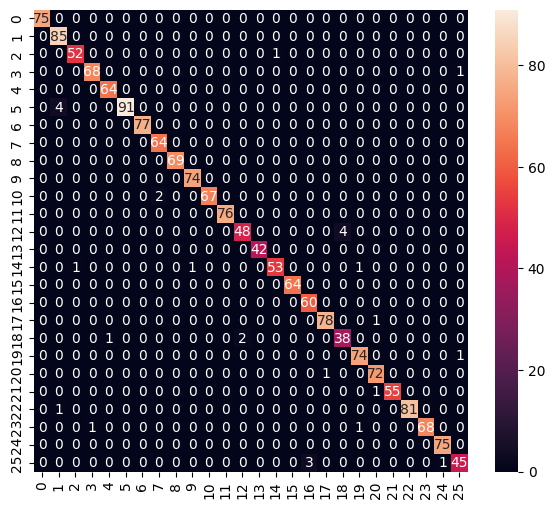

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        75
           1       0.94      1.00      0.97        85
           2       0.98      0.98      0.98        53
           3       0.99      0.99      0.99        69
           4       0.98      1.00      0.99        64
           5       1.00      0.96      0.98        95
           6       1.00      1.00      1.00        77
           7       0.97      1.00      0.98        64
           8       1.00      1.00      1.00        69
           9       0.99      1.00      0.99        74
          10       1.00      0.97      0.99        69
          11       1.00      1.00      1.00        76
          12       0.96      0.92      0.94        52
          13       1.00      1.00      1.00        42
          14       0.98      0.95      0.96        56
          15       1.00      1.00      1.00        64
          16       0.95      1.00      0.98        60
     

In [92]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

# Predictions
Y_pred = model.predict(X_test.reshape(-1, 21, 2, 1))
y_pred = np.argmax(Y_pred, axis=1)

# Display confusion matrix and classification report
print_confusion_matrix(y_test, y_pred)


# Tensorflow-Lite用のモデルへ変換

In [93]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [94]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\GUEST1~1\AppData\Local\Temp\tmp_8dqwr2e\assets


INFO:tensorflow:Assets written to: C:\Users\GUEST1~1\AppData\Local\Temp\tmp_8dqwr2e\assets


64320

# 推論テスト

In [95]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [96]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [97]:
# Reshape the input tensor to match the expected shape of the model
input_data = X_test[0].reshape(1, 21, 2, 1)

# Set the input tensor for the interpreter
interpreter.set_tensor(input_details[0]['index'], input_data)


In [98]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 1.01 ms


In [99]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.8962181e-13 2.0863144e-12 3.2162346e-04 5.3807076e-07 8.8520295e-16
 1.6455906e-10 3.1066224e-07 9.9799013e-01 4.2973611e-06 6.9430121e-06
 1.1624758e-03 6.3382327e-11 1.4924760e-08 1.5743127e-09 4.2604361e-04
 7.8649995e-05 2.2381846e-06 4.6256387e-06 7.6041352e-12 1.5310412e-14
 2.0627255e-07 7.3815343e-08 3.1791455e-08 1.3563585e-09 7.9583874e-12
 1.7670512e-06]
7
